In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import glob
#import bioinfokit 
from bioinfokit import analys, visuz

pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns',85)
pd.set_option('display.max_rows',100)

## my own function that gets the data
from Pi_GetData_fcn import GetData as GetData
from Pi_GetPiOverview_fcn import GetPiOverview as GetPiOverview

In [2]:
# define function
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same')/w

## What you need:
* python functions:
  * **Pi_GetData_fcn.py**
  * **Pi_GetPiOverview_fcn.py**
  * data: 

## What this script does:

- it loads diversity data with the **Pi_GetData_fcn.py** function 
  - in that function it:
      1. shifts the window position so that it applies to the whole genome and not chromosome position
      2. all samples are joined in one data frame
      3. there is df_shiftRaw with the raw data for %-window covered and diversity (e.g. pi diversity) per window
      4. there is also df_shiftNorm with the window pi multiplied with the frac
 - Then, calculate genome-wide pi values either with the raw data or normalised data, with **Pi_GetPiOverview_fcn.py**
    1. pi: uses the raw data, average ove all pi values
    2. piWeight: using the df_shiftNorm data - it evaluates: 
$$\pi_{weight} = \frac{\sum_{i=1}^{n}\pi_{i}\cdot f_{i}}{\sum_{i=1}^{n}f_{i}}$$
      ( before, I had this, but I kicked it out: piNormwNaN: the final value is multiplied with the fraction of windows that are not nan)

In [39]:
# read in data to panda
# get the number of unclassified reads from Kraken2 outputs

InPath="/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/PiDiv_May24/subSample_pool500/"

SamplePattern = "sub50"
files=glob.glob(InPath + "*" + SamplePattern + "*.pi")

outPath = "/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/PiDiv_May24/O_output/"

chromosomes=["NC_003279.8","NC_003280.10","NC_003281.10","NC_003282.8","NC_003283.11","NC_003284.9","NC_001328.1"]
chromosomes_end = [1.50750e+07, 3.03500e+07, 4.41350e+07, 6.16300e+07, 8.25550e+07, 1.00270e+08, 1.00285e+08]

## option: 
#set all windows with less than minCov % covered with usable data to a pi of na
# minCov=0.5


len(files)


534

In [40]:
## get sample names that are in there
samName_collect = []

for i in range(len(files)):
    a = files[i].split('/')
    sample=a[-1].split('_')

    sampleName="_".join(sample[0:4])

    samName_collect.append(sampleName)

samName_unique = np.sort(list(set(samName_collect)))
len(samName_unique)
samName_unique

array(['Gent_bb_15_1', 'Gent_bb_15_2', 'Gent_bb_15_3', 'Gent_bb_15_4',
       'Gent_bb_1_1', 'Gent_bb_1_2', 'Gent_bb_1_3', 'Gent_bb_1_4',
       'Gent_iso_15_1', 'Gent_iso_15_2', 'Gent_iso_15_3', 'Gent_iso_15_4',
       'NIOO_A00_15_1', 'NIOO_A00_15_2', 'NIOO_A00_15_3', 'NIOO_A00_15_4',
       'NIOO_A00_15_5', 'NIOO_A00_1_1', 'NIOO_A00_1_2', 'NIOO_A00_1_3',
       'NIOO_A00_1_4', 'NIOO_A00_1_5', 'NIOO_M00_15_1', 'NIOO_M00_15_3',
       'NIOO_M00_15_4', 'NIOO_M00_15_5', 'NIOO_M00_1_1', 'NIOO_M00_1_3',
       'NIOO_M00_1_4', 'NIOO_M00_1_5', 'NIOO_bb_15_1', 'NIOO_bb_15_3',
       'NIOO_bb_15_4', 'NIOO_bb_1_1', 'NIOO_bb_1_3', 'NIOO_bb_1_4',
       'RUG_bb_15_1', 'RUG_bb_15_2', 'RUG_bb_15_4', 'RUG_bb_15_5',
       'RUG_bb_1_1', 'RUG_bb_1_2', 'RUG_bb_1_4', 'RUG_bb_1_5',
       'UVA_anc_0_1', 'UVA_anc_0_2', 'UVA_anc_0_3', 'UVA_bb_0_1',
       'VU_bb_0_1', 'VU_bb_0_2', 'VU_bb_0_3', 'VU_bb_0_4', 'VU_bb_0_5',
       'VU_bb_15_1', 'VU_bb_15_2', 'VU_bb_15_3', 'VU_bb_15_4',
       'VU_bb_15_5', 'VU

In [41]:
## for the subsampling, get a loop for every sample
numSubSamples = np.zeros(len(samName_unique))
overview_allSubSamples = pd.DataFrame()

for i in range(len(samName_unique)):
    allSub_4_1sample = [s for s in files if samName_unique[i] in s]
   
    numSubSamples[i] = (len(allSub_4_1sample))
    #print("stopp")
    ## use the function to get the data 
    samName_collect, df_shiftRaw, df_shiftNorm, collect_sumofWeights, collect_NanNum = GetData(allSub_4_1sample, chromosomes, chromosomes_end, True)
    
    ## get pi for each of the samples, here they are collected in overview
    overview_1sample = GetPiOverview(samName_collect, df_shiftRaw, df_shiftNorm, collect_sumofWeights, collect_NanNum)
    overview_allSubSamples = pd.concat([overview_allSubSamples, overview_1sample])
    
    ## average over all samples and get a collected df_1sample
    numbers = overview_1sample[["div_mean","div_std","divWeight_mean","divWeight_std"]]
    numbers.mean().div_mean
    
    # now get the averaged over all subsampled samples!
    indices = overview_1sample.index
    df_1sample = overview_1sample.drop(indices[1:])   # first initialize! and only keep the first row!
    
    df_1sample["div_mean"] = numbers.mean().div_mean
    df_1sample["div_std"] = numbers.mean().div_std
    df_1sample["divWeight_mean"] = numbers.mean().divWeight_mean
    df_1sample["divWeight_std"] = numbers.mean().divWeight_std

    df_1sample["NumNaNWindows_mean"] =  np.mean(collect_NanNum)
    #df_1sample["NumNaNWindows_std"] =  np.std(collect_NanNum)

    ## join with the other samples!
    if i==0:                                      ## in the first case, create overview
        overview = df_1sample
    else:                                         ## otherwise "just" add to the bottom
        overview = pd.concat([overview,df_1sample])

overview

,ID,institution,treatment,inst_treat,week,rep,div_mean,div_std,divWeight_mean,divWeight_std,NumNaNWindows_mean
div_Gent_bb_15_1_5,Gent_bb_15_1,Gent,bb,Gent_bb,15,1,0.001673,0.003992,0.001352,0.002431,59.0
div_Gent_bb_15_2_5,Gent_bb_15_2,Gent,bb,Gent_bb,15,2,0.001733,0.003784,0.001491,0.002694,13.0
div_Gent_bb_15_3_2,Gent_bb_15_3,Gent,bb,Gent_bb,15,3,0.001775,0.004024,0.001460,0.002536,18.0
div_Gent_bb_15_4_3,Gent_bb_15_4,Gent,bb,Gent_bb,15,4,0.001751,0.003890,0.001468,0.002614,17.0
div_Gent_bb_1_1_1,Gent_bb_1_1,Gent,bb,Gent_bb,1,1,0.001615,0.003368,0.001512,0.002858,30.0
div_Gent_bb_1_2_3,Gent_bb_1_2,Gent,bb,Gent_bb,1,2,0.001742,0.003810,0.001535,0.002780,5.0
div_Gent_bb_1_3_3,Gent_bb_1_3,Gent,bb,Gent_bb,1,3,0.001708,0.003551,0.001586,0.002964,4.0
div_Gent_bb_1_4_1,Gent_bb_1_4,Gent,bb,Gent_bb,1,4,0.001722,0.003549,0.001611,0.003012,4.0
div_Gent_iso_15_1_3,Gent_iso_15_1,Gent,iso,Gent_iso,15,1,0.001722,0.003638,0.001546,0.002821,5.0
div_Gent_iso_15_2_2,Gent_iso_15_2,Gent,iso,Gent_iso,15,2,0.001768,0.004221,0.001410,0.002165,29.0


In [42]:
overview_allSubSamples

,ID,institution,treatment,inst_treat,week,rep,div_mean,div_std,divWeight_mean,divWeight_std
div_Gent_bb_15_1_5,Gent_bb_15_1,Gent,bb,Gent_bb,15,1,0.001673,0.003994,0.001353,0.002432
div_Gent_bb_15_1_1,Gent_bb_15_1,Gent,bb,Gent_bb,15,1,0.001673,0.003994,0.001353,0.002433
div_Gent_bb_15_1_4,Gent_bb_15_1,Gent,bb,Gent_bb,15,1,0.001673,0.003991,0.001353,0.002432
div_Gent_bb_15_1_2,Gent_bb_15_1,Gent,bb,Gent_bb,15,1,0.001673,0.003993,0.001352,0.002431
div_Gent_bb_15_1_3,Gent_bb_15_1,Gent,bb,Gent_bb,15,1,0.001672,0.003990,0.001351,0.002430
...,...,...,...,...,...,...,...,...,...,...
div_WUR_bleach_15_2_1,WUR_bleach_15_2,WUR,bleach,WUR_bleach,15,2,0.001814,0.004628,0.001438,0.001502
div_WUR_bleach_15_2_4,WUR_bleach_15_2,WUR,bleach,WUR_bleach,15,2,0.001814,0.004625,0.001438,0.001503
div_WUR_bleach_15_2_3,WUR_bleach_15_2,WUR,bleach,WUR_bleach,15,2,0.001815,0.004629,0.001439,0.001504
div_WUR_bleach_15_2_5,WUR_bleach_15_2,WUR,bleach,WUR_bleach,15,2,0.001815,0.004628,0.001439,0.001504


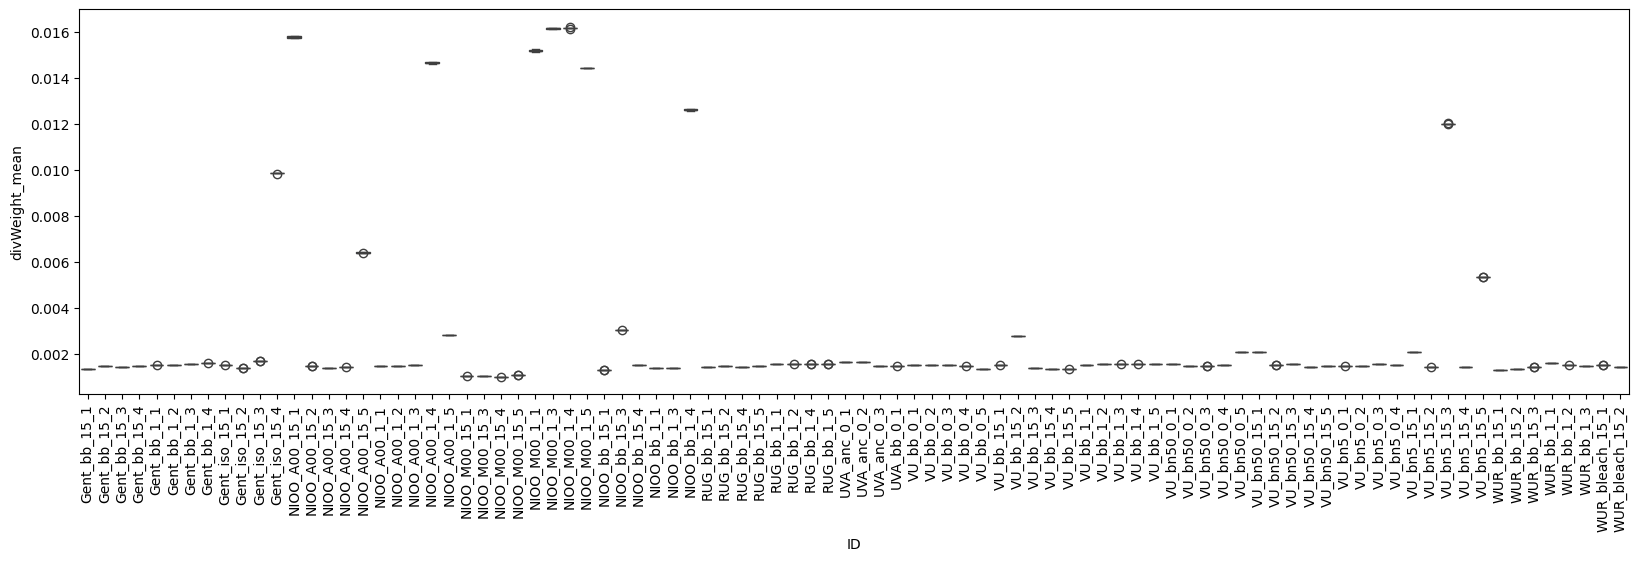

In [43]:
## look at the distribution of pi for all subsamples!!
fig6, ax6 = plt.subplots(figsize=(20,5))
sns.boxplot(x="ID", y="divWeight_mean", data=overview_allSubSamples)
p = plt.xticks(rotation=90, ha='center')

## what doesnt change between different subsamples of the same sample is the fraction of a window that is usable! This is because each sample has the same amount of usable reads per position and 
## thus all have the same fraction. But, pi per window changes

Text(0, 0.5, 'number of subsamples')

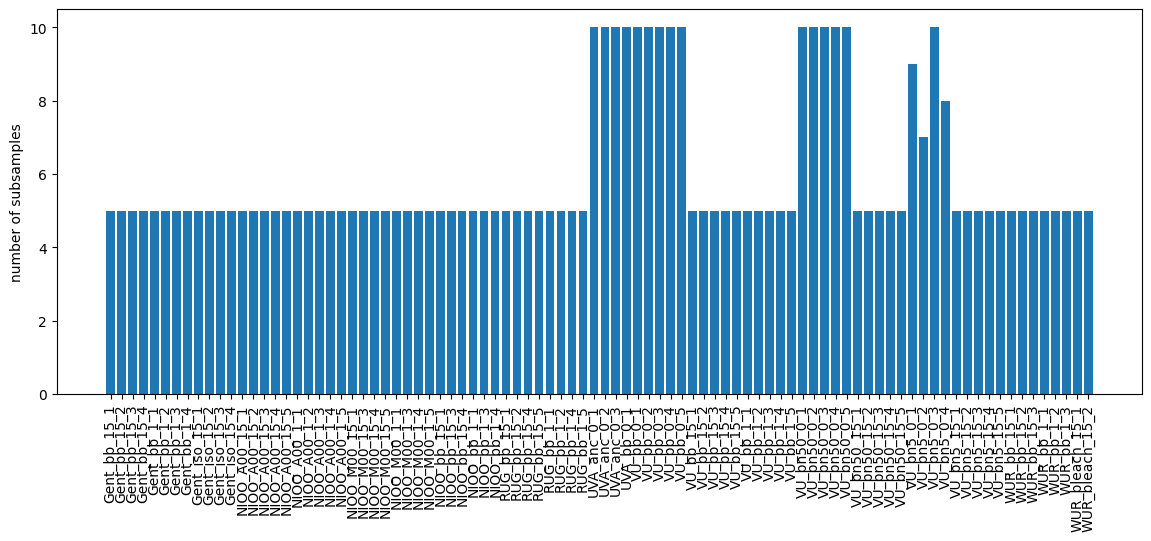

In [44]:
fig4, ax4 = plt.subplots(figsize=(14,5))
ax4.bar(samName_unique, numSubSamples, 0.8)
p = plt.xticks(rotation=90, ha='center')
ax4.set_ylabel("number of subsamples")

Text(0, 0.5, 'number of subsamples')

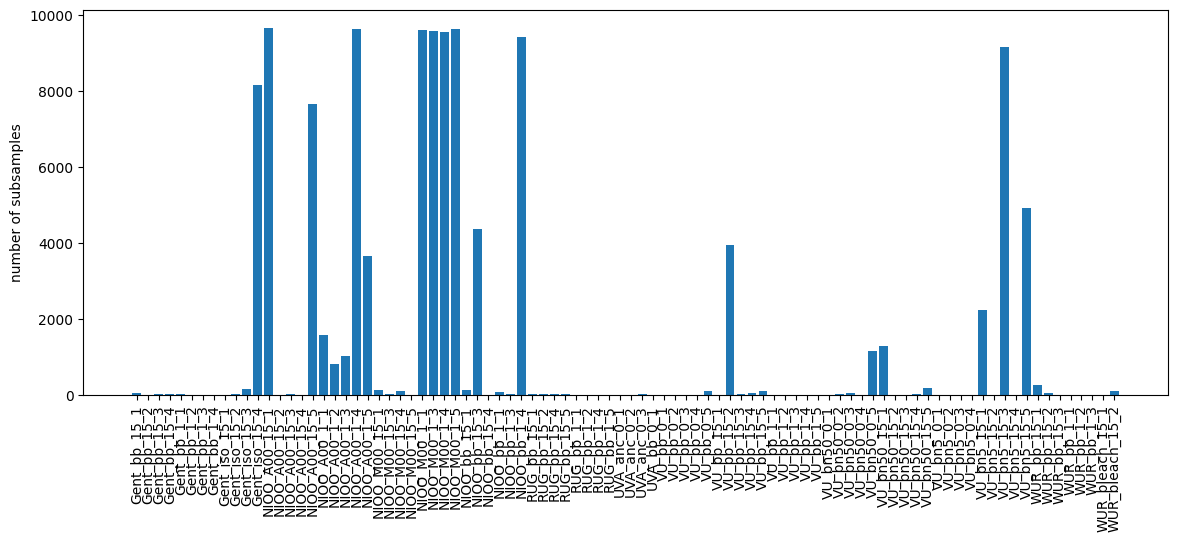

In [45]:
fig5, ax5 = plt.subplots(figsize=(14,5))
ax5.bar(samName_unique, overview["NumNaNWindows_mean"].values, width=0.8)
p = plt.xticks(rotation=90, ha='center')
ax5.set_ylabel("number of subsamples")


In [46]:
type(overview["NumNaNWindows_mean"].values)

numpy.ndarray

In [47]:
### save the data:

overview.to_pickle(outPath + "PiDiversity_Overview" + SamplePattern  + "_20241024.pkl")